# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io, color, feature, transform
from skimage.transform import rescale, resize, rotate
from skimage.data import lfw_subset

#Clasificadores
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


# Encadenar iterables
from itertools import chain

# Proporciona una barra de progreso rápida
from tqdm import tqdm

# Selección aleatoria de una lista sin repetición
from random import sample

# Interfaz para hacer gráficos y visualizaciones
import matplotlib.pyplot as plt

# Computación científica
import numpy as np

# Manipulación de datos
import pandas as pd

# Para guardar y cargar modelos
from joblib import dump, load

# Extraer parches (pequeños subconjuntos de imágenes) de imágenes
from sklearn.feature_extraction.image import PatchExtractor

# data: conjunto de datos de muestra y funciones de carga
# color: convertir imágenes entre espacios de color
# feature: funciones para identificar y extraer características de imágenes
from skimage import data, color, feature

# Cambiar el tamaño de una imagen
from skimage.transform import resize, rescale

# Descarga y carga en memoria un conjunto de datos de imágenes de caras de personas famosas
from sklearn.datasets import fetch_lfw_people

# Regresión logística


# Validación cruzada
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Matriz de confusión
from sklearn.metrics import confusion_matrix

# Exactitud en validación cruzada
from sklearn.model_selection import cross_val_score

# La curva ROC
from sklearn.metrics import roc_curve , auc

# Métricas custom
from sklearn.metrics import make_scorer

# Divide los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Genera un informe detallado de métricas de clasificación
from sklearn.metrics import classification_report

# Funciones para trabajar con la curva ROC y calcular el área bajo la curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

# Genera puntos para visualizar una curva de aprendizaje
from sklearn.model_selection import learning_curve

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


# Funciones auxiliares

### Función para extraer porciones de una imagen 
(Se usa para generar muchas imagenes que no son caras)
Parametros:
- Escala
- Tamaño del patch

In [2]:
def extract_patches(img, N, scale=1.0, patch_size=(62,47)):
    H = img.shape[0]
    W = img.shape[1]
    H_patch = min(H , int(scale * patch_size[0]))
    W_patch = min(W , int(scale * patch_size[1]))
    extracted_patch_size = (H_patch, W_patch)
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])
    return patches

### Sintetizador de rectangulos
Agarra el rectangulo más correcto

In [3]:


def non_max_suppression_average(detections, overlapThresh):
    # Si no hay detecciones, regresar una lista vacía
    if len(detections) == 0:
        return []

    # Convertir las detecciones a un arreglo de NumPy
    detections_array = np.array(detections)

    # Inicializar la lista de detecciones seleccionadas
    pick = []

    # Tomar las coordenadas de los cuadros
    x1 = detections_array[:, 0]
    y1 = detections_array[:, 1]
    x2 = detections_array[:, 0] + detections_array[:, 2]
    y2 = detections_array[:, 1] + detections_array[:, 3]

    # Calcula el área de los cuadros y ordena los cuadros
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(area)

    # Mientras todavía hay índices en la lista de índices
    while len(idxs) > 0:
        # Toma todos los índices de la lista y agrega los índices a la lista de seleccionados
        i = idxs[0]
        pick.append(i)

        # Encuentra las coordenadas (x, y) promedio y el tamaño promedio de la caja
        avg_x1 = np.mean(x1[pick])
        avg_y1 = np.mean(y1[pick])
        avg_w = np.mean(x2[pick] - x1[pick])
        avg_h = np.mean(y2[pick] - y1[pick])

        # Elimina todos los índices del índice de lista que tienen una proporción de superposición mayor que el umbral proporcionado
        idxs = np.delete(idxs, np.where((x1[idxs] < avg_x1 + avg_w) & (y1[idxs] < avg_y1 + avg_h) & (x2[idxs] > avg_x1) & (y2[idxs] > avg_y1))[0])

    # Devuelve solo las detecciones seleccionadas
    return [(avg_x1, avg_y1, avg_w, avg_h) for i in pick]






In [4]:

def non_max_suppression1(detections, overlapThresh):
    # Si no hay detecciones, regresar una lista vacía
    if len(detections) == 0:
        return []

    # Convertir las detecciones a un arreglo de NumPy
    indices = np.array([[d[0], d[1], d[0] + d[2], d[1] + d[3]] for d in detections], dtype=float)

    # Inicializar la lista de detecciones seleccionadas
    pick = []

    # Tomar las coordenadas de los cuadros
    x1 = indices[:, 0]
    y1 = indices[:, 1]
    x2 = indices[:, 2]
    y2 = indices[:, 3]

    # Calcula el área de los cuadros y ordena los cuadros
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(area)

    # Mientras todavía hay índices en la lista de índices
    while len(idxs) > 0:
        # Toma el último índice de la lista y agrega el índice a la lista de seleccionados
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Encontrar las coordenadas (x, y) más grandes para el inicio de la caja y las coordenadas (x, y) más pequeñas para el final de la caja
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calcula el ancho y alto de la caja
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calcula la proporción de superposición
        overlap = (w * h) / area[idxs[:last]]

        # Elimina todos los índices del índice de lista que tienen una proporción de superposición mayor que el umbral proporcionado
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Devuelve solo las detecciones seleccionadas
    return [detections[i] for i in pick]





### TPR y FPR

In [5]:
# True Positive Rate
def tpr_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  tpr = cm[1,1]/(cm[1,1]+cm[1,0])
  return tpr

# False Positive Rate
def fpr_scorer(clf, X, y):
  y_pred = clf.predict(X)
  cm = confusion_matrix(y, y_pred)
  fpr = cm[0,1]/(cm[0,0]+cm[0,1])
  return fpr

### Ventana deslizante

In [6]:
# Define una función para realizar una ventana deslizante (sliding window) sobre una imagen.
def sliding_window(img,
                   patch_size=(62,47),  # Define el tamaño del parche (patch) basado en el primer parche positivo por defecto
                   istep=2,  # Paso de desplazamiento en la dirección i (verticalmente)
                   jstep=2,  # Paso de desplazamiento en la dirección j (horizontalmente)
                   scale=1.0):  # Factor de escala para ajustar el tamaño del parche

    # Calcula las dimensiones Ni y Nj del parche ajustadas por el factor de escala.
    Ni, Nj = (int(scale * s) for s in patch_size)

    # Itera a lo largo de la imagen en la dirección i
    for i in range(0, img.shape[0] - Ni, istep):
        # Itera a lo largo de la imagen en la dirección j
        for j in range(0, img.shape[1] - Ni, jstep):

            # Extrae el parche de la imagen usando las coordenadas actuales i, j.
            patch = img[i:i + Ni, j:j + Nj]

            # Si el factor de escala es diferente de 1, redimensiona el parche al tamaño original del parche.
            if scale != 1:
                patch = resize(patch, patch_size)

            # Usa yield para devolver las coordenadas actuales y el parche.
            # Esto convierte la función en un generador.
            yield (i, j), patch

## Dataset de rostros (LFW)

In [7]:
# Cargamos el dataset de caras
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

## Dataset de fondos

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['camera',
        'text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

backgrounds = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    backgrounds.append(img)

# Imagenes caseras adicionales
for i in range(16):
    filename = str(i)+'.jpg'
    img = plt.imread(filename)
    img = color.rgb2gray(img)
    backgrounds.append(img)

print(len(backgrounds))

26


In [9]:
#model = RandomForestClassifier(n_estimators=20, max_depth=3, random_state=42)
#model = KNeighborsClassifier(n_neighbors=2000)
#model = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, random_state=42)
#model = AdaBoostClassifier(n_estimators=2, learning_rate=0.7, random_state=42)
#model = BaggingClassifier(n_estimators=5, random_state=42)
#model = GradientBoostingClassifier(n_estimators=4, learning_rate=0.8, max_depth=3, random_state=42)

#model = MLPClassifier(hidden_layer_sizes=(1), max_iter=100, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)

# Defino primer modelo

In [10]:


model = LogisticRegression(penalty='l2',C=4, max_iter=1000)
resolution = 1
scales = [0.5,1,2,4,8]
proportion = 10
num_patches = int((proportion * len(positive_patches))/(len(scales) * len(backgrounds)))
orientations = 3
pixels_per_cell = (12, 12)
cells_per_block = (3, 3)

model_name = str(model)
experiment_name = model_name
experiment_name += '_R_' + str(resolution)
experiment_name += '_S_' + str(scales)
experiment_name += '_P_' + str(proportion)
experiment_name += '_O_' + str(orientations)
experiment_name += '_C_' + str(pixels_per_cell)
experiment_name += '_B_' + str(cells_per_block)

#print(experiment_name)

In [11]:
# Tamaño de las imágenes de rostros
positive_patches = np.array(
    [rescale(positive_patches[i],resolution)
    for i in tqdm(range(len(positive_patches)))]
    )
size = positive_patches[0].shape
print(size)

  0%|          | 0/13233 [00:00<?, ?it/s]

100%|██████████| 13233/13233 [00:01<00:00, 9407.26it/s]


(62, 47)


In [12]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack(
    [extract_patches(im, num_patches, scale)
    for im in tqdm(backgrounds, desc='Procesando imágenes')
    for scale in scales]
    )
negative_patches.shape

Procesando imágenes: 100%|██████████| 26/26 [01:56<00:00,  4.48s/it]


(124949, 62, 47)

## Matriz de Features

In [13]:
# Armamos la matriz de features y el vector de etiquetas
X = np.array(
    [feature.hog(image=im,
                 orientations=orientations,
                 pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block)
    for im in tqdm(chain(positive_patches, negative_patches))]
    )
y = np.zeros(X.shape[0])
y[:positive_patches.shape[0]] = 1

print("Matriz de características: ", X.shape)
print("Array de etiquetas: ", y.shape)

138182it [00:26, 5270.47it/s]


Matriz de características:  (138182, 81)
Array de etiquetas:  (138182,)


## Corremos el experimento

Validacion cruzada

In [14]:
# Diccionario de scores
model.fit(X,y)
scoring = {'acc': 'accuracy',
           'prec': 'precision_macro',
           'rec': 'recall_macro',
           'f1':'f1_macro',
           'b_acc': 'balanced_accuracy',
           'auc': 'roc_auc',
           'tpr': tpr_scorer,
           'fpr': fpr_scorer
           }

# Validación cruzada
scores = cross_validate(model,X,y,verbose=2,scoring=scoring,cv=5)

# Nos importan mas los promedios
results = pd.DataFrame(
    data={
        'TIME': scores['fit_time'],
        'ACCURACY': scores['test_acc'],
        'PRECISION': scores['test_prec'],
        'RECALL': scores['test_rec'],
        'F1': scores['test_f1'],
        'B_ACCURACY': scores['test_b_acc'],
        'AUC': scores['test_auc'],
        'TPR': scores['test_tpr'],
        'FPR': scores['test_fpr'],
    }
).mean()
#print(results)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   4.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] END .................................................... total time=   2.1s
[CV] END .................................................... total time=   2.4s
[CV] END .................................................... total time=   3.3s
[CV] END .................................................... total time=   3.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.5s finished


In [15]:
# Podemos guardarlo en un archivo de texto
#results.to_csv(experiment_name + '.txt', header=False)

### Mejor umbral

Umbrales óptimos:
 [0.2568, 0.1792, 0.1315, 0.1119, 0.0719]
Mejor umbral promedio: 0.15025999999999998
Desvío umbral: 0.06348545030162422
FPR promedio: 0.018860000000000002, TPR promedio: 0.9788


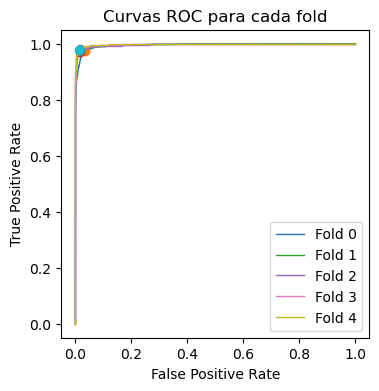

In [16]:
#Esta funcion nos da el mejor umbral para cada fold
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

thrs = []
tprs = []
fprs = []

fig, ax = plt.subplots(figsize=(4, 4))
for fold, (train, test) in enumerate(cv.split(X, y)):
    model.fit(X[train], y[train])
    y_pred = model.predict_proba(X[test])
    y_pred = y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y[test], y_pred)
    gmean = np.sqrt(tpr * (1 - fpr))
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4) #Este es el mejor umbral
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)

    thrs.append(thresholdOpt)
    tprs.append(tprOpt)
    fprs.append(fprOpt)

    ax.step(
        fpr,
        tpr,
        label=f'Fold {fold}',
        lw=1,
        alpha=1,
    )

    ax.plot(
        fprOpt,
        tprOpt,
        marker = 'o'
    )

print(f'Umbrales óptimos:\n {thrs}')
print(f'Mejor umbral promedio: {np.mean(thrs)}')
print(f'Desvío umbral: {np.std(thrs)}')
print(f'FPR promedio: {np.mean(fprs)}, TPR promedio: {np.mean(tprOpt)}')

with open(experiment_name + 'Umbral.txt', 'w') as f:
    f.write('Mejor umbral promedio: ' + str(np.mean(thrs)))
    f.write('\n')
    f.write('FPR promedio: ' + str(np.mean(fprs)) + ' TPR promedio: ' + str(np.mean(tprOpt)))

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Curvas ROC para cada fold",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

# Entrenamiento

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Main

In [ ]:
# Definir y entrenar modelos

modelRF = RandomForestClassifier(n_estimators=20, max_depth=3, random_state=42)
modelRF.fit(X_train,y_train)

modelRL = LogisticRegression(penalty='l2',C=2, max_iter=1000)
modelRL.fit(X_train,y_train)

modelKNN = KNeighborsClassifier(n_neighbors=20)
modelKNN.fit(X_train,y_train)

modelDT = DecisionTreeClassifier(max_depth=3, random_state=42)
modelDT.fit(X_train,y_train)

modelBG = BaggingClassifier(n_estimators=1, random_state=42)
modelBG.fit(X_train,y_train)

modelGB = GradientBoostingClassifier(n_estimators=1, learning_rate=0.3, max_depth=3, random_state=42)
modelGB.fit(X_train,y_train)

modelAB = AdaBoostClassifier(n_estimators=8, learning_rate=0.5, random_state=42)
modelAB.fit(X_train,y_train)

modelMLP = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=100, alpha=0.0001, solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
modelMLP.fit(X_train,y_train)

In [19]:
class ModeloDeCascada(BaseEstimator, ClassifierMixin):
    def __init__(self, models) :
        self.models = models
        self.classes_ = [0, 1]
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, x):
        predictions = []

        for im in x:
            image_ok = True

            for model in self.models:
                prediction = model.predict([im])[0]
                if(prediction == 0): 
                    image_ok = False
                    break
            predictions.append(image_ok)
        return np.array(predictions)



In [ ]:
cascadeModel = ModeloDeCascada(models=[modelRL, modelRF, modelKNN, modelDT, modelGB, modelBG, modelAB, modelMLP])

y_pred = cross_val_predict(cascadeModel, X_train, y_train, cv=5)
accuracy = accuracy_score(y_train, y_pred)
print("Average Accuracy:", accuracy)

precision = precision_score(y_train, y_pred)
print("Average Precision:", precision)


In [21]:
def ProcesarParche(patch): 
    patch_hog = feature.hog(patch,
                            orientations=orientations,
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block)
    
    label = cascadeModel.predict(np.array([patch_hog]))[0]
    if(label == 1):
        return True
    return False

In [22]:
def preprocesamientoImg(img):
    maxResolucionPosible = 1000 #defino la resolucion maxima posible de la foto. Si es mayor, la reduzco
    scales = [4,2,1,0.5] #defino los factores de escala para pasar con la sliding window
    istep = 4 #defino el paso de desplazamiento en la direccion i (verticalmente)
    jstep = 4 #defino el paso de desplazamiento en la direccion j (horizontalmente)

    resolution = max(img.shape)
    if(resolution > 2 * maxResolucionPosible):
       resizor = 0.3
    elif(resolution > maxResolucionPosible):
       resizor = 0.5
    else:
       resizor = 1
    
    return resizor, scales, istep, jstep

In [23]:

def Main(img):
    img = color.rgb2gray(img)
    patch_size=(62,47)
    resizor, scales, istep, jstep = preprocesamientoImg(img)
    if(resizor != 1):
        img = rescale(img, resizor)
        print("La imagen fue reducida a " + str(resizor) + " de su tamaño original")
    detecciones = []
    detecciones_suprimidas = []
    cantDeteccionesPorEscala = 0
    for scale in scales:
        Ni, Nj = (int(scale * s) for s in patch_size) 

        for i in range(0, img.shape[0] - Ni, istep): 
            for j in range(0, img.shape[1] - Nj, jstep):    
                patch = img[i:i + Ni, j:j + Nj] 
                if scale != 1:
                    patch = resize(patch, patch_size) 
                
                if(ProcesarParche(patch)):
                    detecciones.append((i, j, Ni, Nj, scale))         

        print("Cant. detecciones en escala " + str(scale) +  " = "  + str(len(detecciones) - cantDeteccionesPorEscala))
        cantDeteccionesPorEscala = len(detecciones)   
        
    detecciones_suprimidas = non_max_suppression1(detecciones, 0.01)   
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    print(" ")
    print ("Cantidad total de detecciones: " + str(len(detecciones)))
    print("Cantidad de rostros encontrados: " + str(len(detecciones_suprimidas)))
    for deteccion in detecciones_suprimidas:
        i, j, Ni, Nj, scale = deteccion
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
    plt.show()


In [ ]:
test_image = plt.imread('cara4.jpg')
Main(test_image)